# Intent Classification using Keras

In [203]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [204]:
# Data Processing - Main
import numpy as np
import pandas as pd
import re

# Data Processing - Tokenizer and Encoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from sklearn.preprocessing import OneHotEncoder

# Data Processing - Splitting
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout

In [205]:
# test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [206]:
RANDOM_SEED = 13517048
np.random.seed(RANDOM_SEED)

## Data Cleaning

In [207]:
data = pd.read_csv("nlu.csv")
data.head(10)

,text,intent
0,mau absen 11-14 februari 2020,absence
1,mau absen 11 - 14 februari 2020,absence
2,sick leave besok,absence
3,aku mau absence besok,absence
4,change working hours besok,absence
5,change working hour besok,absence
6,absen besok,absence
7,change working hours,absence
8,sick leave,absence
9,mau absen tanggal 10-11 januari 2012,absence


In [208]:
# Clean data:
#   - Strip data from special characters
#   - Tokenize words
#   - Lowercase all word
def clean_data(text_data):
  words = []
  for sentence in text_data:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", sentence)
    tokenized_words = word_tokenize(clean)

    words.append([word.lower() for word in tokenized_words])

  return words

In [209]:
# Get max length of every word in words
def get_max_length(words):
  return len(max(words, key = len))

In [210]:
filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'

def create_tokenizer(words):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [211]:
def create_train_data(text_data):
  # Encoding document
  token = create_tokenizer(text_data)
  sequences = token.texts_to_sequences(text_data)

  max_length = get_max_length(sequences)
  return pad_sequences(sequences, maxlen=max_length, padding="post")

In [212]:
def onehot_encode(data):
  encoder = OneHotEncoder(sparse=False)
  return encoder.fit_transform(data)

In [213]:
cleaned_data = clean_data(data['text'])

In [214]:
tokenizer = create_tokenizer(cleaned_data)
MAX_LENGTH = get_max_length(cleaned_data)
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [215]:
train_data = create_train_data(cleaned_data)
test_data = onehot_encode(data['intent'].values.reshape(-1, 1))

x_train, x_val, y_train, y_val = train_test_split(train_data, test_data, test_size = 0.2)

## Machine Learning Modeling

In [216]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 128, input_length=MAX_LENGTH, trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation = "softmax"))

In [217]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 23, 128)           90624     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 103)               3399      
Total params: 365,415
Trainable params: 274,791
Non-trainable params: 90,624
_________________________________________________________________


### Model Train

In [227]:
# Fit constants

EPOCHS = 250
BASIZE = 32

In [228]:
history = model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BASIZE, validation_data = (x_val, y_val))

Epoch 1/250
39/39 [==============================] - 1s 20ms/step - loss: 1.3494 - accuracy: 0.5945 - val_loss: 2.1015 - val_accuracy: 0.4951
Epoch 2/250
39/39 [==============================] - 1s 19ms/step - loss: 1.3442 - accuracy: 0.5749 - val_loss: 2.1596 - val_accuracy: 0.4951
Epoch 3/250
39/39 [==============================] - 1s 19ms/step - loss: 1.2934 - accuracy: 0.5953 - val_loss: 2.1654 - val_accuracy: 0.4984
Epoch 4/250
39/39 [==============================] - 1s 19ms/step - loss: 1.2865 - accuracy: 0.6026 - val_loss: 2.2417 - val_accuracy: 0.5147
Epoch 5/250
39/39 [==============================] - 1s 20ms/step - loss: 1.2982 - accuracy: 0.6010 - val_loss: 2.4474 - val_accuracy: 0.4886
Epoch 6/250
39/39 [==============================] - 1s 19ms/step - loss: 1.3660 - accuracy: 0.5643 - val_loss: 2.1181 - val_accuracy: 0.5277
Epoch 7/250
39/39 [==============================] - 1s 19ms/step - loss: 1.3014 - accuracy: 0.5888 - val_loss: 2.2191 - val_accuracy: 0.5049
Epoch 

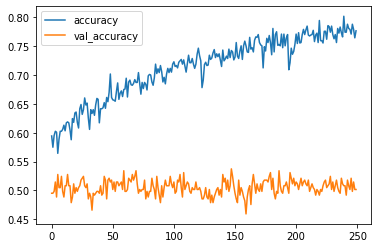

In [229]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])

### Model Predict

In [222]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [223]:
intent_map = {}
for intent, onehot_intent in zip(data['intent'].values, test_data):
  if (intent not in intent_map):
    intent_map[intent] = list(onehot_intent).index(1)

In [224]:
def predict(text):
  # Clean the text first
  cleaned_text = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(cleaned_text)
  test_word = [w.lower() for w in test_word]
  test_ls = tokenizer.texts_to_sequences(test_word)

  # Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
  
  prediction_result = model.predict(x)
  prediction_result = prediction_result[0]

  # convert prediction result to intent word
  unique_intents = np.array(list(set(data['intent'])))

  # sort value by intent ranking
  intent_ranking = {}
  for each_intent in unique_intents:
    intent_ranking[each_intent] = prediction_result[intent_map[each_intent]]

  sorted_intent_ranking = sorted(intent_ranking.items(), key=lambda kv: kv[1], reverse=True)

  print("Intent Ranking:")
  for each_intent in sorted_intent_ranking:
    print(each_intent[0] + "= " + str(each_intent[1]) + " confidence")

In [230]:
predict("register")

Intent Ranking:
revoke_user= 0.16617747 confidence
ask_attendance_formula= 0.12775502 confidence
leave_balance_detail= 0.12523356 confidence
overtime_ask_date= 0.08702212 confidence
balance_previous= 0.07753692 confidence
leave_entry_ask_leave_type= 0.052209374 confidence
reimburse= 0.04508146 confidence
help= 0.041478243 confidence
absence= 0.031810377 confidence
download_payslip= 0.030682942 confidence
approval_status= 0.02245857 confidence
register_user_ask_verification_code= 0.02225953 confidence
balance_next= 0.020277286 confidence
overtime_ask_start_time= 0.018665735 confidence
extend_leave= 0.0155979395 confidence
leave_entry_ask_dates= 0.013586516 confidence
ask_claudia= 0.013022535 confidence
register_user= 0.010078214 confidence
absence_cancellation_ask_parameter= 0.0090470845 confidence
ask_payroll_cutoff_date_select_type= 0.008282969 confidence
cancel= 0.006129073 confidence
leave_entry= 0.0046681184 confidence
snooze_notification= 0.004299617 confidence
thank_you= 0.003982